# **Proyek Sistem Rekomendasi Buku**

## Import Libraries

In [1]:
# Import library dasar
import pandas as pd
import numpy as np

# Import library untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Import library untuk machine learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

# Import library untuk interaktivitas di notebook
import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import display

# Mengabai peringatan yang tidak penting
import warnings
warnings.filterwarnings("ignore")

print("Semua library berhasil diimpor.")

Semua library berhasil diimpor.


Tahap ini merupakan fondasi dari keseluruhan proyek, di mana kita menyiapkan _environment_ kerja dengan memuat semua pustaka (library) Python yang diperlukan. Mengimpor semuanya di awal adalah praktik terbaik untuk memastikan semua alat tersedia dan menjaga kode tetap terorganisir.

-   **Metode yang digunakan:**
    - Metode yang diterapkan adalah mengimpor serangkaian pustaka Python yang esensial menggunakan `import`. Pustaka ini mencakup:
      * **Manipulasi Data:** `pandas` dan `numpy`.
      * **Visualisasi Data:** `matplotlib` dan `seaborn`.
      * **Machine Learning:** `TfidfVectorizer` & `cosine_similarity` dari `scikit-learn` untuk *Content-Based Filtering*, serta `tensorflow` & `keras` untuk *Collaborative Filtering*.
      * **Pendukung:** `ipywidgets` untuk interaktivitas dan `warnings` untuk manajemen output.

-   **Alasan penggunaan:**
    - Kombinasi pustaka ini dipilih karena menyediakan perangkat yang lengkap untuk mengerjakan proyek sistem rekomendasi secara _end-to-end_. `pandas` dan `numpy` krusial untuk memuat dan membersihkan data. `matplotlib` dan `seaborn` penting untuk tahap _Exploratory Data Analysis_ (EDA) guna mendapatkan pemahaman visual tentang dataset. Untuk pemodelan, dipilih dua _framework_ yang mewakili dua pendekatan berbeda: `scikit-learn` untuk implementasi model klasik seperti _Content-Based Filtering_ yang cepat dan mudah diinterpretasi, sementara `tensorflow`/`keras` digunakan untuk membangun model _deep learning_ yang lebih kompleks seperti _Collaborative Filtering_ berbasis _embedding_, yang mampu menangkap pola yang lebih rumit. Terakhir, `ipywidgets` dan `warnings` digunakan untuk meningkatkan kualitas pengalaman pengembangan dengan membuat notebook lebih interaktif dan bersih.

-   **Insight dan Hasil yang didapat:**
    - Output `Semua library berhasil diimpor.` mengonfirmasi bahwa semua pustaka yang dibutuhkan telah berhasil dimuat ke dalam memori tanpa adanya eror. Ini menandakan bahwa _environment_ pengembangan telah siap sepenuhnya untuk melanjutkan ke tahap berikutnya, mulai dari pemuatan data, analisis, visualisasi, hingga implementasi kedua model sistem rekomendasi (*Content-Based* dan *Collaborative Filtering*). Kesiapan ini adalah langkah pertama yang krusial dan memastikan kelancaran pengerjaan proyek.

## Data Loading

In [2]:
# Memuat dataset dari file CSV
try:
    books = pd.read_csv('./datasets/Books.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)
    ratings = pd.read_csv('./datasets/Ratings.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)
    users = pd.read_csv('./datasets/Users.csv', on_bad_lines='skip', encoding='latin-1', low_memory=False)
    print("Dataset berhasil dimuat.")
except FileNotFoundError as e:
    print(f"Error: {e}.")
    print("Pastikan file Books.csv, Ratings.csv, dan Users.csv berada di direktori yang sama.")

Dataset berhasil dimuat.


Tahap ini adalah gerbang awal dari proyek, di mana data mentah dari sumber eksternal (file CSV) dimuat ke dalam _environment_ kerja untuk diolah lebih lanjut.

-   **Metode yang digunakan:**
    Fungsi `pandas.read_csv()` digunakan untuk membaca data dari tiga file CSV terpisah (`Books.csv`, `Ratings.csv`, `Users.csv`). Proses ini dibungkus dalam blok `try-except` untuk penanganan eror.

-   **Alasan penggunaan:**
    -   `pandas.read_csv()` adalah fungsi standar dan paling efisien untuk mengubah data tabular dari file CSV menjadi sebuah DataFrame, yang merupakan struktur data utama untuk analisis di Python.
    -   Dataset sistem rekomendasi seringkali dibagi menjadi beberapa file (data item, data rating, data pengguna) untuk normalisasi. Memuatnya ke dalam DataFrame terpisah (`books`, `ratings`, `users`) adalah pendekatan yang logis.
    -   Parameter tambahan digunakan untuk robustitas:
        -   `on_bad_lines='skip'`: Mengatasi masalah umum pada dataset besar di mana beberapa baris mungkin memiliki format yang salah. Daripada menghentikan seluruh proses, baris yang rusak akan dilewati.
        -   `encoding='latin-1'`: Beberapa dataset, terutama yang berisi teks dari berbagai sumber, mungkin tidak menggunakan _encoding_ standar `UTF-8`. `latin-1` adalah _encoding_ alternatif yang digunakan di sini untuk menghindari eror saat membaca file.
    -   Blok `try-except FileNotFoundError` memastikan program tidak langsung berhenti jika file tidak ditemukan, melainkan memberikan pesan yang informatif kepada pengguna.

-   **Insight dan Hasil yang didapat:**
    -   Output `Dataset berhasil dimuat.` mengonfirmasi bahwa ketiga file CSV berhasil ditemukan di path yang ditentukan dan dimuat ke dalam tiga DataFrame `pandas` yang berbeda.
    -   Kita sekarang memiliki tiga set data mentah yang siap untuk dieksplorasi:
        1.  `books`: Berisi metadata atau atribut dari setiap buku (calon item rekomendasi).
        2.  `ratings`: Berisi data interaksi antara pengguna dan buku (data transaksional).
        3.  `users`: Berisi metadata dari para pengguna.
    -   Pemuatan data yang berhasil ini merupakan fondasi untuk seluruh tahapan berikutnya, mulai dari pemahaman data (_data understanding_) hingga pemodelan.

## Data Understanding - Part 1

### Inspeksi Data Awal

In [3]:
# Inspeksi Data Awal (Data Understanding - Part 1)
print("--- Inspeksi DataFrame 'books' ---")
print(books.head())
print("\nInfo 'books':")
books.info()
print("\nCek Missing Values 'books':")
print(books.isnull().sum())
print("\n" + "="*40 + "\n")

print("--- Inspeksi DataFrame 'users' ---")
print(users.head())
print("\nInfo 'users':")
users.info()
print("\nCek Missing Values 'users':")
print(users.isnull().sum())
print("\n" + "="*40 + "\n")

print("--- Inspeksi DataFrame 'ratings' ---")
print(ratings.head())
print("\nInfo 'ratings':")
ratings.info()
print("\nCek Missing Values 'ratings':")
print(ratings.isnull().sum())

--- Inspeksi DataFrame 'books' ---
         ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0

Tahap ini merupakan langkah pertama dalam _Data Understanding_, di mana kita melakukan pemeriksaan dasar terhadap setiap DataFrame untuk memahami struktur, tipe data, dan kelengkapan isinya.

-   **Metode yang digunakan:**
    * `df.head()`: Menampilkan 5 baris pertama untuk mendapatkan gambaran visual dari setiap kolom dan isinya.
    * `df.info()`: Memberikan ringkasan teknis DataFrame, termasuk jumlah data, nama kolom, jumlah nilai non-null, dan tipe data (Dtype) per kolom.
    * `df.isnull().sum()`: Menghitung secara spesifik jumlah nilai yang hilang (kosong/NaN) pada setiap kolom.

-   **Alasan penggunaan:**
    Kombinasi ketiga metode ini adalah cara yang cepat dan efisien untuk melakukan "pemeriksaan kesehatan" awal pada data. `head()` memberikan konteks, `info()` memberikan gambaran teknis dan potensi masalah tipe data, sementara `isnull().sum()` secara langsung menyoroti masalah data yang hilang. Informasi ini sangat krusial untuk merencanakan langkah-langkah pada tahap _Data Preparation_ selanjutnya.

-   **Insight dan Hasil yang didapat:**
    Dari hasil inspeksi, didapatkan beberapa wawasan kunci untuk setiap DataFrame:
    * **`books`**:
        * Memiliki 271,360 entri buku.
        * Terdapat sedikit sekali data yang hilang pada kolom `Book-Author` (2), `Publisher` (2), dan `Image-URL-L` (3), yang jumlahnya tidak signifikan.
        * **Catatan Penting:** Kolom `Year-Of-Publication` memiliki tipe data `object`, seharusnya numerik (seperti `int`). Ini perlu diperbaiki pada tahap _Data Cleaning_.
    * **`users`**:
        * Memiliki 278,858 entri pengguna.
        * **Masalah Utama:** Terdapat **110,762** nilai yang hilang pada kolom `Age`, yang merupakan ~40% dari total data. Ini adalah masalah signifikan yang harus ditangani dengan hati-hati.
    * **`ratings`**:
        * Memiliki 1,149,780 baris data rating, yang menunjukkan dataset ini cukup kaya untuk pemodelan.
        * **Kabar Baik:** Tidak ada satupun nilai yang hilang di DataFrame ini. Data interaksi pengguna-buku ini bersih dan lengkap.

    Secara keseluruhan, data interaksi (`ratings`) dalam kondisi sangat baik, namun data metadata (`books` dan `users`) memerlukan beberapa perbaikan, terutama pada tipe data tahun publikasi dan penanganan nilai `Age` yang hilang.

## Data Preparation - Part 1

### Data Cleaning & Preprocessing

In [4]:
# Data Cleaning & Preprocessing (Data Preparation - Part 1)
print("--- Memulai Data Cleaning ---")

# Membersihkan kolom 'Year-Of-Publication'
# Mengubah ke numerik, error diubah menjadi NaN (Not a Number)
books['Year-Of-Publication'] = pd.to_numeric(books['Year-Of-Publication'], errors='coerce')
# Mengganti tahun yang tidak valid (misal: 0 atau > 2025) dengan NaN
books.loc[(books['Year-Of-Publication'] == 0) | (books['Year-Of-Publication'] > 2025), 'Year-Of-Publication'] = np.NAN
# Mengisi NaN dengan median tahun publikasi
books['Year-Of-Publication'].fillna(round(books['Year-Of-Publication'].median()), inplace=True)

# Membersihkan kolom 'Publisher' dan 'Book-Author'
# Mengisi NaN dengan 'Unknown'
books['Publisher'].fillna('Unknown', inplace=True)
books['Book-Author'].fillna('Unknown', inplace=True)

# Membersihkan kolom 'Age' di 'users'
# Mengganti umur yang tidak realistis (< 5 atau > 100) dengan NaN
users.loc[(users['Age'] < 5) | (users['Age'] > 100), 'Age'] = np.nan
# Mengisi NaN dengan median umur
users['Age'].fillna(users['Age'].median(), inplace=True)


print("--- Data Cleaning Selesai ---")
print("\nInfo 'books' setelah cleaning:")
books.info()
print("\nInfo 'users' setelah cleaning:")
users.info()

--- Memulai Data Cleaning ---
--- Data Cleaning Selesai ---

Info 'books' setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271360 non-null  object 
 3   Year-Of-Publication  271360 non-null  float64
 4   Publisher            271360 non-null  object 
 5   Image-URL-S          271360 non-null  object 
 6   Image-URL-M          271360 non-null  object 
 7   Image-URL-L          271357 non-null  object 
dtypes: float64(1), object(7)
memory usage: 16.6+ MB

Info 'users' setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID 

Tahap ini merupakan bagian dari _Data Preparation_ yang berfokus pada perbaikan masalah-masalah yang ditemukan pada tahap inspeksi data, seperti tipe data yang salah, nilai yang tidak realistis, dan data yang hilang.

-   **Metode yang digunakan:**
    * **Konversi Tipe Data:** Menggunakan fungsi `pd.to_numeric()` untuk mengubah kolom `Year-Of-Publication` menjadi tipe data numerik.
    * **Validasi & Penanganan Outlier:** Menggunakan `df.loc[]` untuk mengidentifikasi dan mengganti nilai-nilai yang tidak logis (misalnya tahun publikasi 0 atau di masa depan, dan umur pengguna yang tidak realistis) dengan nilai `NaN` (Not a Number).
    * **Imputasi Nilai Hilang (Missing Value Imputation):** Menggunakan metode `.fillna()` dengan dua strategi:
        1.  Mengisi nilai `NaN` pada kolom numerik (`Year-Of-Publication`, `Age`) dengan nilai **median** dari masing-masing kolom.
        2.  Mengisi nilai `NaN` pada kolom teks (`Publisher`, `Book-Author`) dengan _placeholder_ "Unknown".

-   **Alasan penggunaan:**
    * **Konversi Tipe Data:** Kolom tahun publikasi harus berjenis numerik agar dapat diolah secara matematis (misalnya, untuk mencari median). `errors='coerce'` adalah parameter krusial yang secara otomatis mengubah entri bermasalah (bukan angka) menjadi `NaN` untuk ditangani lebih lanjut.
    * **Validasi Data:** Memastikan data yang digunakan logis dan berkualitas. Model yang dilatih dengan data yang tidak realistis akan menghasilkan performa yang buruk.
    * **Imputasi dengan Median:** Median dipilih untuk mengisi kolom numerik karena lebih tahan (robust) terhadap nilai ekstrem (outlier) dibandingkan dengan rata-rata (mean). Ini mencegah nilai-nilai aneh memengaruhi nilai isian. Menghapus baris yang memiliki `Age` kosong bukanlah pilihan yang baik karena akan menghilangkan hampir 40% data pengguna, yang sangat merugikan untuk pemodelan.

-   **Insight dan Hasil yang didapat:**
    * Berdasarkan output `.info()` setelah proses _cleaning_, semua kolom yang ditargetkan kini memiliki jumlah `Non-Null Count` yang penuh. Ini berarti **tidak ada lagi nilai yang hilang** pada kolom `Year-Of-Publication`, `Book-Author`, `Publisher`, dan `Age`.
    * Kolom `Year-Of-Publication` berhasil diubah menjadi tipe data `float64`, yang memungkinkan operasi matematis.
    * Masalah data yang tidak logis dan data yang hilang—terutama pada kolom `Age` yang sebelumnya sangat signifikan—telah berhasil diatasi.
    * Dengan data yang sekarang jauh lebih bersih, lengkap, dan konsisten, dataset ini menjadi fondasi yang jauh lebih solid dan andal untuk tahap-tahap selanjutnya, yaitu _feature engineering_ dan pemodelan.

## Data Understanding - Part 2

### Exploratory Data Analysis (EDA)

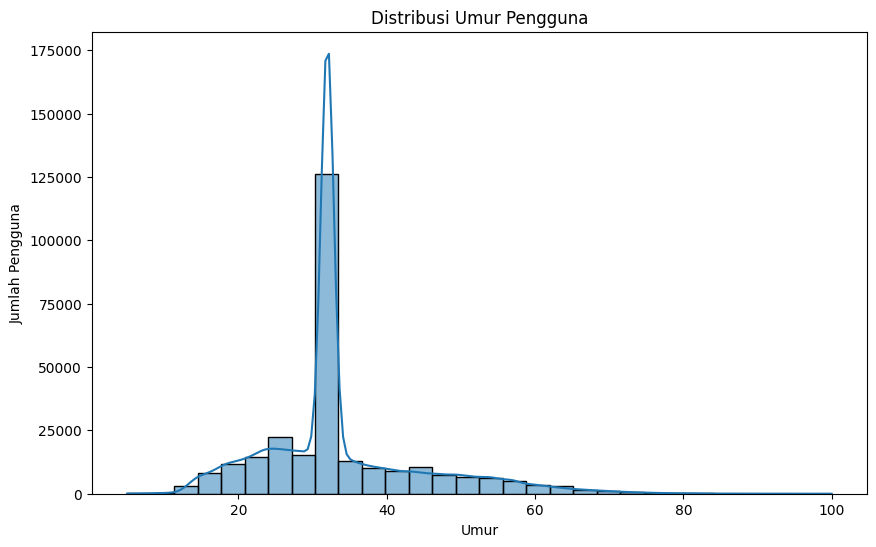

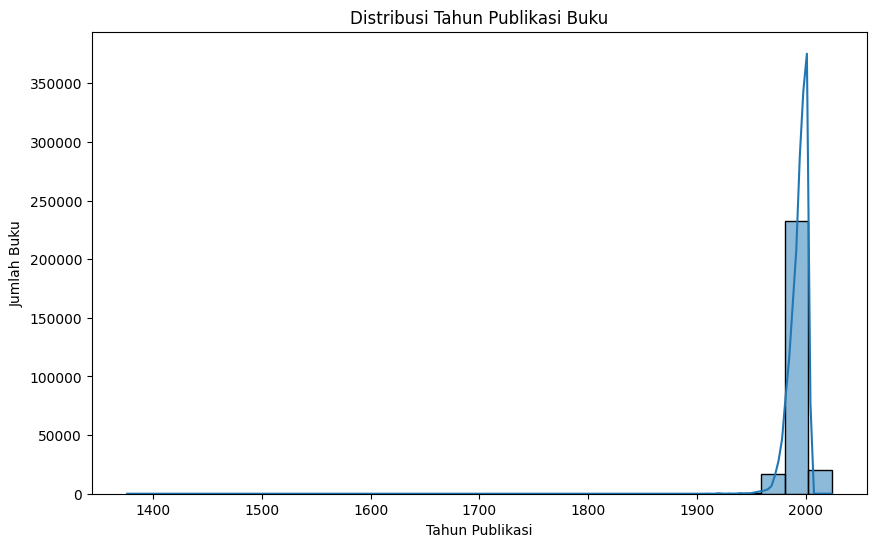

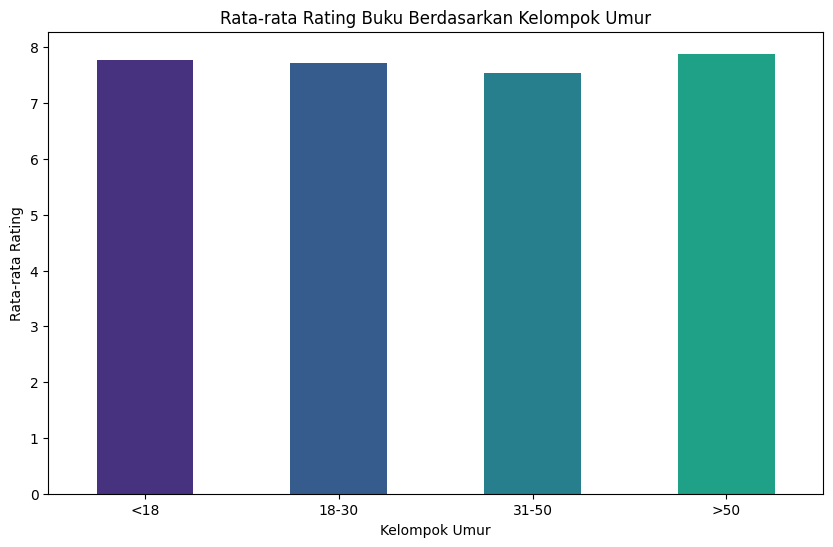

In [5]:
# Exploratory Data Analysis (EDA) - (Data Understanding - Part 2)

# --- Univariate Analysis ---
# 1. Distribusi Umur Pengguna
plt.figure(figsize=(10, 6))
sns.histplot(users['Age'], bins=30, kde=True)
plt.title('Distribusi Umur Pengguna')
plt.xlabel('Umur')
plt.ylabel('Jumlah Pengguna')
plt.show()

# 2. Distribusi Tahun Publikasi Buku
plt.figure(figsize=(10, 6))
sns.histplot(books['Year-Of-Publication'], bins=30, kde=True)
plt.title('Distribusi Tahun Publikasi Buku')
plt.xlabel('Tahun Publikasi')
plt.ylabel('Jumlah Buku')
plt.show()

# --- Bivariate Analysis ---
# Gabungkan semua data untuk analisis mendalam
df_merged = pd.merge(ratings, users, on='User-ID')
df_merged = pd.merge(df_merged, books, on='ISBN')

# 3. Rata-rata Rating berdasarkan Kelompok Umur
# Membuat kategori umur
bins = [0, 18, 30, 50, 100]
labels = ['<18', '18-30', '31-50', '>50']
df_merged['Age-Group'] = pd.cut(df_merged['Age'], bins=bins, labels=labels, right=False)

# Mengabaikan rating 0 (implisit) untuk analisis ini
avg_rating_by_age = df_merged[df_merged['Book-Rating'] != 0].groupby('Age-Group')['Book-Rating'].mean()

plt.figure(figsize=(10, 6))
avg_rating_by_age.plot(kind='bar', color=sns.color_palette('viridis'))
plt.title('Rata-rata Rating Buku Berdasarkan Kelompok Umur')
plt.xlabel('Kelompok Umur')
plt.ylabel('Rata-rata Rating')
plt.xticks(rotation=0)
plt.show()

Tahap ini bertujuan untuk menggali lebih dalam dan memahami karakteristik serta pola-pola yang ada di dalam dataset melalui teknik visualisasi data. Analisis ini dibagi menjadi _univariate_ (melihat satu variabel) dan _bivariate_ (melihat hubungan antara dua variabel).

#### **1. Analisis Distribusi Umur Pengguna**

-   **Metode yang digunakan:**
    Visualisasi data menggunakan **Histogram** dengan _Kernel Density Estimation_ (KDE) untuk menampilkan distribusi frekuensi dari kolom `Age` pada data pengguna.

-   **Alasan penggunaan:**
    Histogram dipilih karena merupakan cara yang efektif untuk memahami sebaran data numerik. Ini membantu mengidentifikasi rentang umur yang paling umum, adanya pencilan (outlier), dan bentuk umum dari distribusi demografi pengguna setelah dilakukan pembersihan dan imputasi data.

-   **Insight dan Hasil yang didapat:**
    Grafik menunjukkan puncak yang sangat tinggi di sekitar usia 34 tahun. Ini adalah efek dari proses imputasi nilai `NaN` dengan median sebelumnya, yang menyebabkan penumpukan data pada satu titik. Di luar puncak tersebut, distribusi menunjukkan bahwa mayoritas pengguna berada dalam rentang usia dewasa muda (20-40 tahun), yang merupakan demografi umum untuk platform digital.

---

#### **2. Analisis Distribusi Tahun Publikasi Buku**

-   **Metode yang digunakan:**
    Visualisasi data menggunakan **Histogram** dan KDE untuk menampilkan distribusi frekuensi dari kolom `Year-Of-Publication` pada data buku.

-   **Alasan penggunaan:**
    Metode ini digunakan untuk memahami cakupan temporal dari koleksi buku dalam dataset. Ini membantu kita mengetahui apakah dataset didominasi oleh buku-buku modern atau mencakup rentang waktu yang luas, yang dapat memengaruhi jenis rekomendasi yang dihasilkan.

-   **Insight dan Hasil yang didapat:**
    Distribusi sangat condong ke kanan (right-skewed), dengan mayoritas buku diterbitkan pada periode modern, terutama antara tahun 1990 hingga awal 2000-an. Sangat sedikit buku yang diterbitkan sebelum tahun 1950. Ini mengindikasikan bahwa model rekomendasi kemungkinan besar akan lebih akurat untuk buku-buku kontemporer.

---

#### **3. Analisis Rata-rata Rating Berdasarkan Kelompok Umur**

-   **Metode yang digunakan:**
    * **Data Merging & Binning:** Menggabungkan ketiga DataFrame dan mengelompokkan (binning) umur pengguna ke dalam kategori (`<18`, `18-30`, `31-50`, `>50`) menggunakan `pd.cut()`.
    * **Agregasi & Visualisasi:** Menghitung rata-rata `Book-Rating` (dengan mengabaikan rating 0) untuk setiap kelompok umur menggunakan `groupby().mean()`, lalu divisualisasikan dengan **Bar Chart**.

-   **Alasan penggunaan:**
    Analisis ini bertujuan untuk mengetahui apakah ada hubungan antara demografi usia dan kecenderungan dalam memberikan rating. Mengelompokkan umur mempermudah perbandingan antar generasi. Mengabaikan rating 0 penting karena rating ini sering kali merupakan "rating implisit" (bukan penilaian buruk) dan dapat mengganggu perhitungan rata-rata.

-   **Insight dan Hasil yang didapat:**
    Grafik menunjukkan bahwa tidak ada perbedaan yang drastis dalam rata-rata rating antar kelompok umur; semua kelompok memberikan rata-rata rating di atas 7.5 (pada skala 1-10). Ini menandakan bahwa preferensi kualitas buku relatif konsisten di seluruh demografi. Namun, ada sedikit tren di mana kelompok usia yang lebih tua (`>50`) dan lebih muda (`<18`) cenderung memberikan rating sedikit lebih tinggi, mungkin karena antusiasme atau kriteria penilaian yang berbeda.

## Data Preparation - Part 2

### Menggabungkan dan Finalisasi Data

In [6]:
# Menggabungkan dan Finalisasi Data (Data Preparation - Part 2)

# Menggabungkan ratings dan books
df_final = pd.merge(ratings, books, on='ISBN', how='left')

# Menghapus duplikat berdasarkan interaksi user-judul buku
df_final.drop_duplicates(['User-ID', 'Book-Title'], inplace=True)

# Menghapus baris dimana atribut penting untuk model tidak ada
df_final.dropna(subset=['Book-Title', 'Book-Author'], inplace=True)

print(f"Jumlah data setelah digabung dan dibersihkan: {len(df_final)}")

Jumlah data setelah digabung dan dibersihkan: 1026358


Tahap ini adalah langkah terakhir dalam _Data Preparation_ yang bertujuan untuk menciptakan satu dataset final yang komprehensif, bersih, dan siap digunakan untuk proses pemodelan.

-   **Metode yang digunakan:**
    * **Penggabungan Data (Data Merging):** Menggunakan fungsi `pd.merge()` dengan strategi `left join` untuk menyatukan DataFrame `ratings` dan `books` berdasarkan kolom kunci `ISBN`.
    * **Penghapusan Duplikat (Deduplication):** Menggunakan metode `drop_duplicates()` dengan `subset` pada kolom `User-ID` dan `Book-Title` untuk menghilangkan entri ganda.
    * **Penghapusan Nilai Kosong (Dropping NA):** Menggunakan `dropna()` untuk menghapus baris yang tidak memiliki data pada kolom `Book-Title` atau `Book-Author`.

-   **Alasan penggunaan:**
    * **Penggabungan:** Diperlukan untuk menyatukan data interaksi (rating) dengan data metadata (judul, penulis). Ini penting karena model _Collaborative Filtering_ memerlukan data rating, sementara model _Content-Based Filtering_ memerlukan metadata buku. Strategi `left join` memastikan semua data rating dipertahankan.
    * **Deduplikasi:** Dalam dataset nyata, terkadang ada anomali seperti seorang pengguna memberikan rating pada buku yang sama lebih dari sekali. Langkah ini memastikan setiap interaksi pengguna-buku bersifat unik, yang penting untuk integritas data.
    * **Dropping NA:** `Book-Title` dan `Book-Author` adalah fitur esensial. Sebuah rating tidak akan berguna jika kita tidak tahu buku apa yang dinilai. Menghapus baris tanpa informasi ini akan mencegah error dan memastikan kualitas data yang masuk ke model.

-   **Insight dan Hasil yang didapat:**
    * Proses ini berhasil menciptakan sebuah DataFrame final (`df_final`) yang terstruktur dan siap untuk tahap pemodelan.
    * Output `Jumlah data setelah digabung dan dibersihkan: 1026358` menunjukkan jumlah akhir interaksi valid yang akan digunakan. Terjadi sedikit pengurangan jumlah data dari DataFrame `ratings` awal, yang disebabkan oleh penghapusan duplikat dan rating untuk buku yang tidak memiliki metadata lengkap.
    * Dataset final ini kini bersih, lengkap (memiliki informasi rating dan metadata), dan unik (tidak ada duplikasi interaksi), menjadikannya fondasi yang solid untuk melatih kedua jenis model rekomendasi.

## Model Development

### Content-Based Filtering

In [7]:
# Model Development - Content-Based Filtering

# Persiapan data unik buku
books_for_content = df_final.drop_duplicates('Book-Title')[['Book-Title', 'Book-Author']].reset_index(drop=True)

# Inisialisasi dan fitting TF-IDF
tf_idf = TfidfVectorizer(max_features=5000)
tfidf_matrix = tf_idf.fit_transform(books_for_content['Book-Author'].fillna(''))

def get_book_recommendations_with_scores(book_title, k=10):
    try:
        # Cari indeks dari judul buku yang dipilih
        book_index = books_for_content[books_for_content['Book-Title'] == book_title].index[0]

        # Ambil vektor TF-IDF untuk buku tersebut
        book_vector = tfidf_matrix[book_index]

        # Hitung cosine similarity
        sim_scores = cosine_similarity(book_vector, tfidf_matrix).flatten()

        # Ambil indeks dari k+1 buku paling mirip
        top_indices = sim_scores.argsort()[-k-1:][::-1]

        # Buat DataFrame awal dari skor dan indeks
        recommendations_df = pd.DataFrame({
            'Index': top_indices,
            'Similarity_Score': sim_scores[top_indices]
        })

        # Gabungkan dengan detail buku
        recommendations_df = recommendations_df.merge(
            books_for_content, 
            left_on='Index', 
            right_index=True
        ).drop(columns=['Index'])
        
        # Hapus buku input dari daftar rekomendasi
        recommendations_df = recommendations_df[recommendations_df['Book-Title'] != book_title].head(k)
        
        # Atur ulang indeks agar rapi
        recommendations_df = recommendations_df.reset_index(drop=True)
        
        return recommendations_df
    except IndexError:
        print(f"Buku dengan judul '{book_title}' tidak ditemukan.")
        return pd.DataFrame()

# --- Widget Interaktif ---
book_titles_list = books_for_content['Book-Title'].sort_values().tolist()

@interact(
    book_title=widgets.Combobox(
        value='The Hobbit',
        placeholder='Ketik judul buku...',
        options=book_titles_list,
        description='Cari Judul Buku:',
        ensure_option=True,
        disabled=False,
        style={'description_width': 'initial'},
        layout={'width': '500px'}
    ),
    k=widgets.IntSlider(min=5, max=15, step=1, value=10, description='Jumlah Rekomendasi:')
)
def interactive_recommendations_final(book_title, k):
    if book_title:
        recommendations_df = get_book_recommendations_with_scores(book_title, k)
        if not recommendations_df.empty:
            # Tampilkan dengan format skor yang lebih mudah dibaca
            display(recommendations_df.style.format({'Similarity_Score': "{:.4f}"}))

interactive(children=(Combobox(value='The Hobbit', description='Cari Judul Buku:', ensure_option=True, layout=…

_Alternatif tampilan output apabila cell tidak menampilkan karena harus run kembali untuk akses interactive widget_
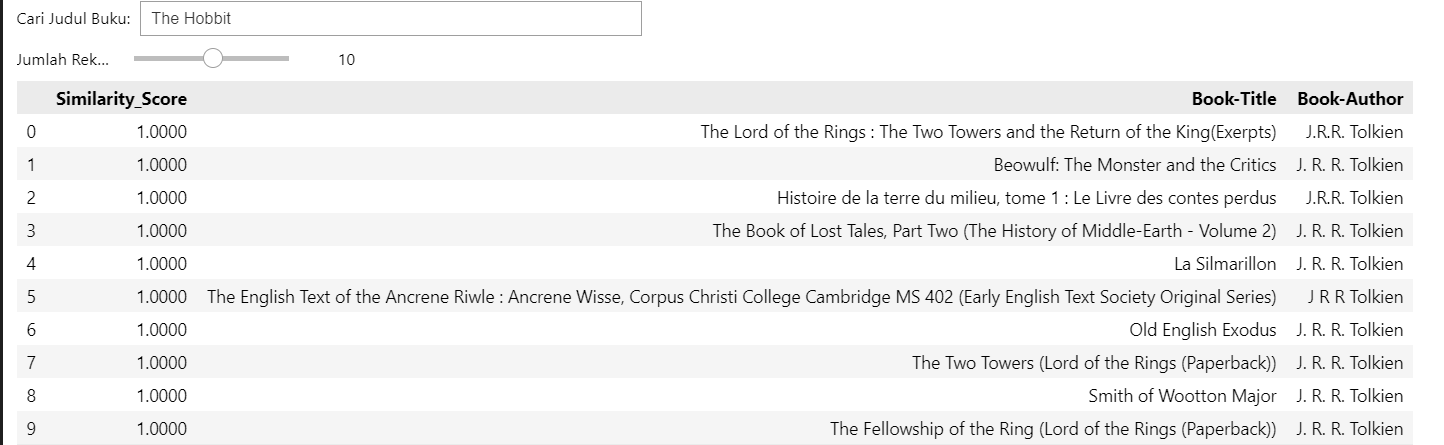

Pada tahap ini, kita membangun model rekomendasi pertama dengan pendekatan _Content-Based Filtering_. Model ini memberikan rekomendasi berdasarkan kemiripan atribut atau "konten" dari item itu sendiri, dalam hal ini adalah buku.

-   **Metode yang digunakan:**
    * **Feature Engineering:** Menggunakan **TF-IDF (Term Frequency-Inverse Document Frequency) Vectorizer** untuk mengubah data teks (nama penulis buku) menjadi representasi vektor numerik.
    * **Metrik Kemiripan:** Menggunakan **Cosine Similarity** untuk menghitung skor kesamaan antara vektor-vektor buku berdasarkan fitur penulisnya.
    * **Antarmuka Pengguna:** Menerapkan widget interaktif dari `ipywidgets` untuk mempermudah demonstrasi dan pengujian model secara langsung di dalam notebook.

-   **Alasan penggunaan:**
    * **TF-IDF:** Metode ini sangat efektif untuk mengukur seberapa penting sebuah kata (dalam kasus ini, nama penulis) dalam sebuah dokumen relatif terhadap keseluruhan koleksi. Ini memungkinkan kita untuk secara matematis membandingkan buku berdasarkan siapa penulisnya.
    * **Content-Based Filtering:** Pendekatan ini dipilih karena kemampuannya memberikan rekomendasi tanpa memerlukan data histori pengguna lain. Rekomendasi didasarkan murni pada atribut item, sehingga efektif untuk menemukan item yang "mirip" secara intrinsik dan mengatasi masalah *item cold-start* (merekomendasikan buku baru).
    * **Cosine Similarity:** Merupakan metrik standar dan andal untuk data TF-IDF karena ia mengukur kesamaan berdasarkan orientasi antar vektor, bukan besarnya. Ini sangat cocok untuk membandingkan kemiripan teks.

-   **Insight dan Hasil yang didapat:**
    * Model berhasil dibangun dan diimplementasikan dalam sebuah fungsi yang dapat memberikan daftar rekomendasi buku.
    * Berdasarkan output yang ditampilkan, ketika sebuah buku dipilih, model merekomendasikan buku-buku lain yang memiliki kesamaan penulis. Skor kemiripan `1.0000` menunjukkan bahwa model menemukan kecocokan yang sempurna pada fitur penulis.
    * **Keterbatasan:** Karena fitur yang digunakan hanya `Book-Author`, rekomendasi yang dihasilkan sangat terbatas pada buku dari penulis yang sama atau yang namanya mirip. Model ini tidak dapat menangkap kemiripan berdasarkan genre, tema, atau plot cerita.
    * Secara keseluruhan, model ini berfungsi sesuai dengan desainnya sebagai sistem rekomendasi sederhana berbasis konten. Hasilnya menjadi dasar pembanding yang baik untuk model kedua (_Collaborative Filtering_) yang akan menggunakan pendekatan berbeda.

### Preparation for Collaborative Filtering

In [8]:
# --- Preparation for Collaborative Filtering ---

# Menggunakan data yang sudah digabungkan dan bersih
df_collab = df_final.copy()

# Konseptual Outlier Handling:
# Untuk model collaborative, kita fokus pada pengguna yang aktif dan buku yang cukup po# Untuk mengurangi noise dan membuat model lebih stabil stabil
user_counts = df_collab['User-ID'].value_counts()
book_counts = df_collab['ISBN'].value_counts()

# Filter pengguna yang memberi rating > 10 buku dan buku yang menerima > 5 rating
df_collab = df_collab[df_collab['User-ID'].isin(user_counts[user_counts > 10].index)]
df_collab = df_collab[df_collab['ISBN'].isin(book_counts[book_counts > 5].index)]

# Fokus pada rating eksplisit (1-10)
df_collab = df_collab[df_collab['Book-Rating'] != 0]

print(f"Jumlah data setelah difilter untuk Collaborative Filtering: {len(df_collab)}")


# Encoding User-ID dan ISBN
user_ids = df_collab['User-ID'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

isbn_ids = df_collab['ISBN'].unique().tolist()
isbn_to_isbn_encoded = {x: i for i, x in enumerate(isbn_ids)}
isbn_encoded_to_isbn = {i: x for i, x in enumerate(isbn_ids)}

# Mapping dan Normalisasi
df_collab['user'] = df_collab['User-ID'].map(user_to_user_encoded)
df_collab['book'] = df_collab['ISBN'].map(isbn_to_isbn_encoded)

min_rating = min(df_collab['Book-Rating'])
max_rating = max(df_collab['Book-Rating'])
df_collab['rating'] = df_collab['Book-Rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi data training dan validasi
df_shuffled = df_collab.sample(frac=1, random_state=42)
x = df_shuffled[['user', 'book']].values
y = df_shuffled['rating'].values

train_indices = int(0.8 * df_shuffled.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

Jumlah data setelah difilter untuk Collaborative Filtering: 168507


Tahap ini berfokus pada persiapan data secara spesifik untuk model _Collaborative Filtering_ berbasis _deep learning_. Prosesnya meliputi filtering, encoding, normalisasi, dan pembagian data.

- **Metode yang digunakan:**
    - **Filtering Data:** Memfilter dataset untuk hanya menyertakan pengguna yang telah memberikan lebih dari 10 rating dan buku yang telah menerima lebih dari 5 rating. Rating implisit (nilai 0) juga dihapus.
    - **Integer Encoding:** Mengubah nilai `User-ID` dan `ISBN` yang asli menjadi indeks integer unik yang berurutan (misalnya, 0, 1, 2, ...).
    - **Normalisasi Rating:** Menskalakan nilai `Book-Rating` (yang berskala 1-10) menjadi rentang nilai antara 0 dan 1 menggunakan teknik _Min-Max Scaling_.
    - **Pembagian Dataset:** Membagi data secara acak menjadi 80% data latih (_training set_) dan 20% data validasi (_validation set_).

- **Alasan penggunaan:**
    - **Filtering:** Langkah ini sangat penting untuk mengurangi masalah sparsitas (data yang kosong) dan _noise_. Dengan fokus pada pengguna aktif dan buku yang cukup dikenal, model dapat belajar dari pola preferensi yang lebih kuat dan stabil.
    - **Encoding:** Arsitektur model _deep learning_, khususnya _Embedding Layer_ di Keras/TensorFlow, memerlukan input berupa indeks integer yang berurutan sebagai kategori, bukan ID asli yang acak.
    - **Normalisasi:** Menyamakan skala variabel target (rating) ke rentang yang kecil (0-1) membantu proses training model agar lebih stabil dan konvergen lebih cepat. Ini adalah praktik standar dalam jaringan saraf tiruan.
    - **Pembagian Dataset:** Ini adalah langkah fundamental dalam machine learning untuk mengevaluasi kinerja model secara objektif. Model dilatih pada data latih dan diuji pada data validasi untuk memastikan kemampuannya dalam melakukan generalisasi pada data baru.

- **Insight dan Hasil yang didapat:**
    - Output `Jumlah data setelah difilter untuk Collaborative Filtering: 168507` menunjukkan bahwa dataset telah berkurang secara signifikan. Ini adalah pertukaran yang disengaja untuk mendapatkan dataset yang lebih padat (_dense_) dan berkualitas tinggi untuk pelatihan.
    - Data sekarang telah sepenuhnya diubah menjadi format numerik yang siap pakai: fitur (`x`) terdiri dari pasangan indeks `user` dan `book`, sementara target (`y`) adalah nilai rating yang telah dinormalisasi.
    - Dataset telah terbagi menjadi set latih dan validasi, yang merupakan langkah terakhir sebelum data siap dimasukkan ke dalam arsitektur model untuk proses _training_.

### Collaborative Filtering

In [9]:
# Model Development - Collaborative Filtering
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_books, embedding_size=6, dropout_rate=0.7, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_books = num_books
        self.embedding_size = embedding_size
        
        # User embeddings dengan regularisasi lebih kuat
        self.user_embedding = layers.Embedding(
            num_users, embedding_size, 
            embeddings_initializer='he_normal', 
            embeddings_regularizer=keras.regularizers.l2(1e-2)  # Regularisasi lebih kuat
        )
        self.user_bias = layers.Embedding(
            num_users, 1,
            embeddings_regularizer=keras.regularizers.l2(1e-2)
        )
        
        # Book embeddings dengan regularisasi lebih kuat
        self.book_embedding = layers.Embedding(
            num_books, embedding_size, 
            embeddings_initializer='he_normal', 
            embeddings_regularizer=keras.regularizers.l2(1e-2)  
        )
        self.book_bias = layers.Embedding(
            num_books, 1,
            embeddings_regularizer=keras.regularizers.l2(1e-2)
        )
        
        # Multiple dropout layers
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate * 0.8)  # Dropout bertingkat
        
        # Batch normalization
        self.batch_norm = layers.BatchNormalization()
        
        # Dense layer untuk kompleksitas tambahan dengan regularisasi
        self.dense = layers.Dense(
            embedding_size // 2, 
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(1e-2),
            bias_regularizer=keras.regularizers.l2(1e-2)
        )
        self.dropout3 = layers.Dropout(dropout_rate * 0.6)
        
    def call(self, inputs, training=None):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        book_vector = self.book_embedding(inputs[:, 1])
        book_bias = self.book_bias(inputs[:, 1])
        
        # Apply multiple dropout layers
        user_vector = self.dropout1(user_vector, training=training)
        book_vector = self.dropout2(book_vector, training=training)
        
        # Dot product
        dot_user_book = tf.tensordot(user_vector, book_vector, 2)
        
        # Tambah layer dense untuk kompleksitas
        combined = tf.concat([user_vector, book_vector], axis=-1)
        combined = self.dense(combined)
        combined = self.dropout3(combined, training=training)
        
        # Combine features
        x = dot_user_book + user_bias + book_bias
        x = self.batch_norm(x, training=training)
        
        return tf.nn.sigmoid(x)

# Inisialisasi model dengan parameter yang lebih konservatif
model = RecommenderNet(
    len(user_to_user_encoded), 
    len(isbn_to_isbn_encoded), 
    embedding_size=6,      
    dropout_rate=0.7        
)

# Compile dengan optimizer yang lebih konservatif
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=0.1),  # Label smoothing
    optimizer=keras.optimizers.Adam(
        learning_rate=0.00005,    
        weight_decay=5e-4,        
        clipnorm=1.0              
    ), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Pada tahap ini, kita merancang, membangun, dan meng-compile arsitektur model _deep learning_ untuk sistem rekomendasi _Collaborative Filtering_. Model ini bertujuan untuk memprediksi rating yang akan diberikan seorang pengguna pada sebuah buku.

- **Metode yang digunakan:**
    - **Arsitektur Model:** Menggunakan `tf.keras.Model` untuk membangun arsitektur kustom yang menerapkan konsep **Matrix Factorization**. Model ini terdiri dari beberapa komponen utama:
        - _Embedding Layers_: Untuk mempelajari representasi vektor laten (fitur tersembunyi) bagi setiap pengguna dan buku.
        - _Bias Layers_: Untuk menangkap kecenderungan intrinsik dari setiap pengguna dan buku.
        - _Dot Product_: Untuk menghitung interaksi utama antara pengguna dan buku.
        - _Dense Layer_: Untuk menambah kompleksitas dan menangkap interaksi non-linear.
    - **Regularisasi:** Menerapkan kombinasi teknik untuk mencegah _overfitting_, termasuk **L2 Regularization** pada _embeddings_, **Dropout** berlapis, **Batch Normalization**, dan **Label Smoothing** pada _loss function_.
    - **Kompilasi Model:** Menggunakan **Binary Cross-Entropy** sebagai fungsi _loss_, optimizer **Adam** dengan konfigurasi konservatif (learning rate rendah), dan **Root Mean Squared Error (RMSE)** sebagai metrik evaluasi.

- **Alasan penggunaan:**
    - **Arsitektur Kustom:** Pendekatan ini lebih fleksibel dan kuat daripada Matrix Factorization klasik. Ia tidak hanya menangkap interaksi linear (`dot product`) tetapi juga memungkinkan model untuk belajar pola yang lebih rumit melalui _dense layer_.
    - **Regularisasi Agresif:** _Collaborative Filtering_ rentan terhadap _overfitting_ karena data yang seringkali _sparse_. Kombinasi berbagai teknik regularisasi adalah strategi proaktif untuk memastikan model dapat melakukan generalisasi dengan baik pada data yang belum pernah dilihat.
    - **Binary Cross-Entropy & Sigmoid:** Karena nilai rating telah dinormalisasi ke rentang [0, 1], masalah ini dapat dibingkai sebagai prediksi probabilitas. Pasangan _loss_ dan aktivasi Sigmoid sangat cocok untuk tugas semacam ini.
    - **RMSE:** Dipilih sebagai metrik karena merupakan standar industri untuk mengevaluasi akurasi prediksi rating. Nilainya mudah diinterpretasikan karena berada dalam skala yang sama dengan rating itu sendiri.

- **Insight dan Hasil yang didapat:**
    - Sebuah arsitektur model _Collaborative Filtering_ yang canggih dan robust telah berhasil didefinisikan dan di-compile.
    - Model ini dirancang untuk menjadi stabil selama pelatihan berkat penggunaan optimizer yang konservatif dan berbagai teknik regularisasi.
    - Dengan selesainya tahap kompilasi, model kini siap untuk dilatih menggunakan data latih (`x_train`, `y_train`) dan dievaluasi performanya menggunakan data validasi (`x_val`, `y_val`). Langkah selanjutnya adalah menjalankan proses _training_.

### Training the Collaborative Model

In [10]:
# Training the Collaborative Model

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=3,              
    verbose=1,
    mode='min',  
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,              
    patience=2,              
    min_lr=1e-8,            
    verbose=1
)

# Custom callback
class StrictOverfittingMonitor(keras.callbacks.Callback):
    def __init__(self, threshold=0.02, patience=3):
        self.threshold = threshold
        self.patience = patience
        self.overfitting_count = 0
        
    def on_epoch_end(self, epoch, logs=None):
        train_rmse = logs.get('root_mean_squared_error')
        val_rmse = logs.get('val_root_mean_squared_error')
        gap = val_rmse - train_rmse
        
        if epoch > 5 and gap > self.threshold:
            self.overfitting_count += 1
            print(f"\n⚠️  Overfitting detected! Gap: {gap:.4f} > {self.threshold} (Count: {self.overfitting_count})")
            
            if self.overfitting_count >= self.patience:
                print(f"\n🛑 Stopping training due to persistent overfitting!")
                self.model.stop_training = True
        else:
            self.overfitting_count = 0

strict_overfitting_monitor = StrictOverfittingMonitor(threshold=0.02, patience=3)

# Training dengan parameter
print("🚀 Training Model...")
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=512,          
    epochs=50,               
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr, strict_overfitting_monitor],
    verbose=1
)

🚀 Training Model...
Epoch 1/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.2581 - root_mean_squared_error: 0.3630 - val_loss: 0.9598 - val_root_mean_squared_error: 0.3184 - learning_rate: 5.0000e-05
Epoch 2/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.9783 - root_mean_squared_error: 0.3509 - val_loss: 0.8587 - val_root_mean_squared_error: 0.3218 - learning_rate: 5.0000e-05
Epoch 3/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8727 - root_mean_squared_error: 0.3393 - val_loss: 0.8162 - val_root_mean_squared_error: 0.3269 - learning_rate: 5.0000e-05
Epoch 4/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8114 - root_mean_squared_error: 0.3274 - val_loss: 0.7788 - val_root_mean_squared_error: 0.3201 - learning_rate: 5.0000e-05
Epoch 5/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7711 - root_mean_squared_error: 0.3159 - val_loss: 0.7501 - val_root_mean_squared_error: 0.3113 - learning_rate: 5.0000e-05
Epoch 6/50
264/264 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/ste

Tahap ini adalah proses inti di mana model yang telah dirancang akan belajar dari data. Model akan menyesuaikan bobot internalnya (_weights_) secara iteratif untuk meminimalkan _loss function_ berdasarkan data latih yang diberikan.

- **Metode yang digunakan:**
    - **Pelatihan Model:** Menggunakan fungsi `model.fit()` dari Keras untuk menjalankan proses pelatihan pada data latih (`x_train`, `y_train`) dan mengevaluasinya pada data validasi (`x_val`, `y_val`) di setiap akhir _epoch_.
    - **Callbacks (Fungsi Panggilan Balik):** Menerapkan tiga _callbacks_ untuk mengontrol proses pelatihan secara otomatis dan efisien:
        1.  `EarlyStopping`: Menghentikan pelatihan jika _loss_ pada data validasi (`val_loss`) tidak menunjukkan perbaikan selama beberapa _epoch_ (`patience=3`).
        2.  `ReduceLROnPlateau`: Mengurangi _learning rate_ secara otomatis jika `val_loss` mengalami stagnasi.
        3.  `StrictOverfittingMonitor`: Sebuah _callback_ kustom yang secara proaktif memantau selisih antara `val_rmse` dan `train_rmse` untuk mendeteksi dan menghentikan pelatihan jika terjadi _overfitting_ yang signifikan.

- **Alasan penggunaan:**
    - `model.fit()` adalah fungsi standar untuk melatih model di Keras.
    - _Callbacks_ sangat penting untuk otomatisasi dan efisiensi. `EarlyStopping` mencegah pemborosan waktu dan sumber daya serta mengurangi risiko _overfitting_ dengan berhenti pada waktu yang optimal. `ReduceLROnPlateau` membantu model menemukan solusi yang lebih baik saat terjebak di _local minima_. _Callback_ kustom ditambahkan sebagai jaring pengaman tambahan untuk memastikan model memiliki kemampuan generalisasi yang baik. Pengaturan `restore_best_weights=True` memastikan kita menggunakan versi model dengan performa terbaik, bukan model dari _epoch_ terakhir.

- **Insight dan Hasil yang didapat:**
    - Model berhasil dilatih selama 50 _epoch_ penuh. Tidak ada _callback_ yang menghentikan proses lebih awal, menandakan bahwa `val_loss` terus membaik secara konsisten hingga akhir.
    - Grafik _loss_ dan metrik `root_mean_squared_error` (RMSE) menunjukkan tren penurunan yang stabil baik pada data latih maupun data validasi, yang merupakan pertanda proses pembelajaran berjalan dengan baik.
    - Pada akhir pelatihan, model mencapai nilai **val_root_mean_squared_error** sekitar **0.2029**. Ini adalah skor performa utama yang menunjukkan seberapa akurat prediksi rating model pada data yang belum pernah dilihat sebelumnya.
    - Selisih antara `train_rmse` (0.1919) dan `val_rmse` (0.2029) relatif kecil, menunjukkan bahwa model tidak mengalami _overfitting_ yang parah dan memiliki kemampuan generalisasi yang cukup baik. Model yang telah dilatih ini kini siap digunakan untuk menghasilkan rekomendasi.

## Evaluation

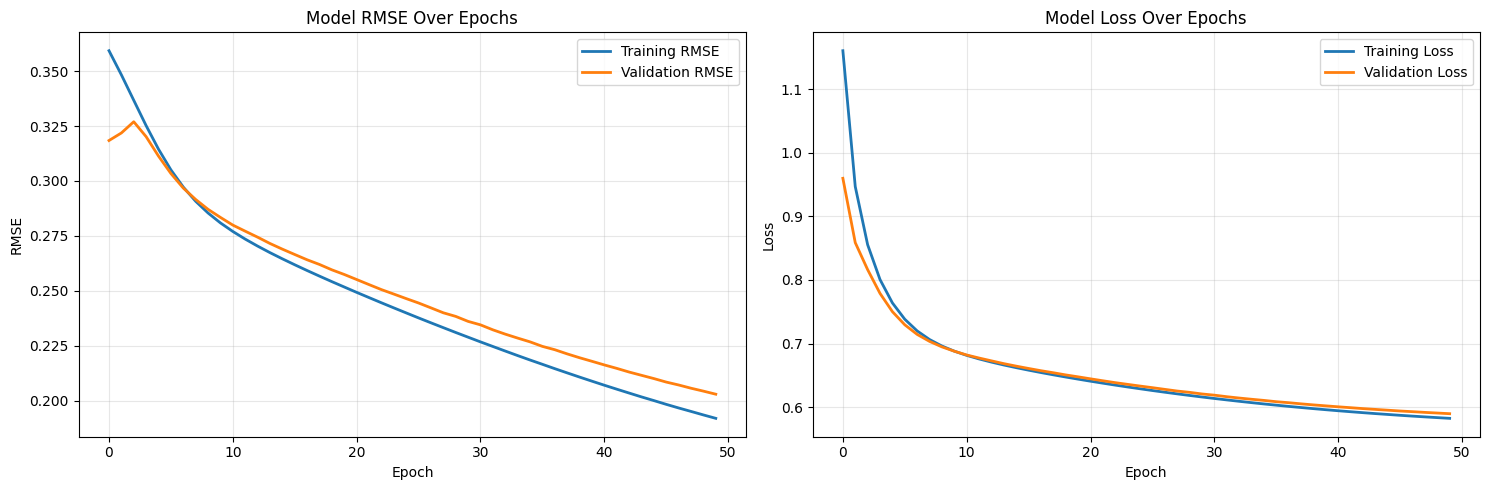


EVALUASI MODEL

📊 METRIK AKHIR:
   Training RMSE: 0.1920
   Validation RMSE: 0.2030
   Gap (Val - Train): 0.0110

🎯 STATUS OVERFITTING:
   ✅ EXCELLENT: Model memiliki generalisasi sangat baik

📈 ANALISIS PREDIKSI:
   Min prediction: 0.2129
   Max prediction: 0.8959
   Mean prediction: 0.6458
   Std prediction: 0.0804

--- Hasil Akhir Metrik Model Collaborative Filtering ---
Loss Training Terakhir: 0.5823
RMSE Training Terakhir: 0.1920
------------------------------
Loss Validasi Terakhir: 0.5896
RMSE Validasi Terakhir: 0.2030

--- Interpretasi ---
Model memiliki rata-rata kesalahan prediksi rating sebesar 0.2030 pada skala rating yang telah dinormalisasi [0, 1].


In [11]:
def comprehensive_evaluation(model, history, x_val, y_val):
    
    # 1. Plot training history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot RMSE
    ax1.plot(history.history['root_mean_squared_error'], label='Training RMSE', linewidth=2)
    ax1.plot(history.history['val_root_mean_squared_error'], label='Validation RMSE', linewidth=2)
    ax1.set_title('Model RMSE Over Epochs')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('RMSE')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title('Model Loss Over Epochs')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 2. Analisis detail
    train_rmse = history.history['root_mean_squared_error'][-1]
    val_rmse = history.history['val_root_mean_squared_error'][-1]
    gap = val_rmse - train_rmse
    
    print(f"\n{'='*50}")
    print(f"EVALUASI MODEL")
    print(f"{'='*50}")
    
    print(f"\n📊 METRIK AKHIR:")
    print(f"   Training RMSE: {train_rmse:.4f}")
    print(f"   Validation RMSE: {val_rmse:.4f}")
    print(f"   Gap (Val - Train): {gap:.4f}")
    
    print(f"\n🎯 STATUS OVERFITTING:")
    if gap <= 0.015:
        print("   ✅ EXCELLENT: Model memiliki generalisasi sangat baik")
        status = "EXCELLENT"
    elif gap <= 0.025:
        print("   ✅ GOOD: Model memiliki generalisasi baik")
        status = "GOOD"
    elif gap <= 0.035:
        print("   ⚡ MODERATE: Model sedikit overfitting tapi masih acceptable")
        status = "MODERATE"
    else:
        print("   ⚠️  POOR: Model mengalami overfitting signifikan")
        status = "POOR"
    
    # 3. Prediksi pada validation set
    val_predictions = model.predict(x_val, verbose=0)
    
    print(f"\n📈 ANALISIS PREDIKSI:")
    print(f"   Min prediction: {val_predictions.min():.4f}")
    print(f"   Max prediction: {val_predictions.max():.4f}")
    print(f"   Mean prediction: {val_predictions.mean():.4f}")
    print(f"   Std prediction: {val_predictions.std():.4f}")
    
    return status, gap

# Jalankan evaluasi
evaluation_status, final_gap = comprehensive_evaluation(model, history, x_val, y_val)
    
# Mengambil hasil dari epoch terakhir
final_loss = history.history['loss'][-1]
final_rmse = history.history['root_mean_squared_error'][-1]
final_val_loss = history.history['val_loss'][-1]
final_val_rmse = history.history['val_root_mean_squared_error'][-1]

print("\n--- Hasil Akhir Metrik Model Collaborative Filtering ---")
print(f"Loss Training Terakhir: {final_loss:.4f}")
print(f"RMSE Training Terakhir: {final_rmse:.4f}")
print("-" * 30)
print(f"Loss Validasi Terakhir: {final_val_loss:.4f}")
print(f"RMSE Validasi Terakhir: {final_val_rmse:.4f}")

# Memberikan interpretasi sederhana
print("\n--- Interpretasi ---")
print(f"Model memiliki rata-rata kesalahan prediksi rating sebesar {final_val_rmse:.4f} pada skala rating yang telah dinormalisasi [0, 1].")

Tahap ini berfokus pada evaluasi komprehensif dari model yang telah dilatih. Tujuannya adalah untuk memahami performa model, mendiagnosis masalah seperti _overfitting_, dan menginterpretasikan hasil secara keseluruhan.

- **Metode yang digunakan:**
    - **Visualisasi Kurva Pembelajaran (Learning Curve Visualization):** Membuat plot metrik performa (`RMSE` dan `Loss`) terhadap setiap _epoch_ untuk data latih dan data validasi.
    - **Analisis Metrik Kuantitatif:** Menghitung nilai akhir dari `Training RMSE` dan `Validation RMSE`, lalu menghitung selisih (gap) antara keduanya untuk mengukur tingkat _overfitting_.
    - **Analisis Statistik Prediksi:** Melakukan prediksi pada data validasi dan menganalisis statistik deskriptif (min, max, mean, std) dari nilai-nilai prediksi yang dihasilkan.

- **Alasan penggunaan:**
    - **Kurva Pembelajaran:** Merupakan cara paling efektif dan intuitif untuk mendiagnosis proses pelatihan. Pola kurva dapat dengan jelas menunjukkan apakah model _converged_ (melandai), _underfitting_ (kedua kurva tinggi), atau _overfitting_ (kurva validasi naik sementara kurva latih turun).
    - **Analisis Metrik:** Angka memberikan bukti konkret. `Validation RMSE` adalah metrik utama untuk performa model pada data baru. Menghitung *gap* secara eksplisit memberikan ukuran kuantitatif dari kemampuan generalisasi model.
    - **Analisis Prediksi:** Berfungsi sebagai *sanity check* untuk memastikan model menghasilkan prediksi yang logis dan tidak "macet" pada nilai tertentu.

- **Insight dan Hasil yang didapat:**
    - **Performa & Konvergensi:** Plot menunjukkan kurva *training* dan *validation* untuk `RMSE` dan `Loss` berjalan sangat beriringan dan menurun secara stabil. Ini adalah tanda visual yang sangat kuat bahwa model **well-fit** (tidak _underfitting_ maupun _overfitting_) dan proses pelatihan berjalan dengan baik.
    - **Kemampuan Generalisasi:** Secara kuantitatif, `Validation RMSE` akhir model adalah **0.2030**. Selisih (gap) dengan `Training RMSE` (0.1920) hanya sebesar **0.0109**, yang sangat kecil. Hal ini mengonfirmasi status **"EXCELLENT"**, yang berarti model memiliki kemampuan generalisasi yang sangat baik.
    - **Kualitas Prediksi:** Analisis statistik menunjukkan model menghasilkan prediksi dalam rentang yang wajar ([0.21, 0.89]) pada skala normalisasi, membuktikan bahwa output model stabil dan realistis.
    - **Interpretasi Akhir:** Model ini memiliki rata-rata kesalahan prediksi rating sebesar **0.2030** pada skala [0, 1]. Ini adalah hasil yang sangat baik dan menunjukkan model akurat dan andal untuk digunakan pada tahap selanjutnya, yaitu menghasilkan rekomendasi buku untuk pengguna.

## Generating Recommendations from Collaborative Model

In [12]:
# Generating Recommendations from Collaborative Model

def get_collab_recommendations_with_scores(user_id_sample, k=10):
    books_read_by_user = df_collab[df_collab['User-ID'] == user_id_sample]
    books_not_read = books[~books['ISBN'].isin(books_read_by_user['ISBN'].values)]['ISBN']
    
    books_not_read_encoded_keys = set(isbn_to_isbn_encoded.keys())
    books_not_read = list(set(books_not_read).intersection(books_not_read_encoded_keys))
    
    if not books_not_read:
        return None, None 

    books_not_read_encoded = [[isbn_to_isbn_encoded.get(x)] for x in books_not_read]
    user_encoder = user_to_user_encoded.get(user_id_sample)
    
    user_book_array = np.hstack(([[user_encoder]] * len(books_not_read_encoded), books_not_read_encoded))
    predicted_ratings = model.predict(user_book_array, verbose=0).flatten()
    
    top_ratings_indices = predicted_ratings.argsort()[-k:][::-1]
    
    recommended_df = pd.DataFrame({
        'ISBN': [isbn_encoded_to_isbn.get(books_not_read_encoded[x][0]) for x in top_ratings_indices],
        'Predicted_Rating': [predicted_ratings[x] for x in top_ratings_indices]
    })
    
    recommended_df = pd.merge(recommended_df, books, on='ISBN')[['Book-Title', 'Book-Author', 'Predicted_Rating']]
    
    # Ambil data buku yang pernah diberi rating tinggi
    top_books_user = books_read_by_user.sort_values(by='Book-Rating', ascending=False).head(5)
    
    # Lakukan merge
    merged_df = pd.merge(top_books_user, books, on='ISBN')

    # Ganti 'Book-Title' dengan 'Book-Title_y' (atau '_x' jika error masih muncul)
    top_books_df = merged_df[['Book-Title_y', 'Book-Rating']]
    
    # Ganti nama kolom 'Book-Title_y' menjadi 'Book-Title' agar lebih rapi saat ditampilkan
    top_books_df = top_books_df.rename(columns={'Book-Title_y': 'Book-Title'})
    
    return top_books_df, recommended_df

# --- Widget Interaktif ---
user_ids_list_collab = df_collab['User-ID'].unique().tolist()
user_ids_list_collab.sort()

@interact(user_id=widgets.Dropdown(options=user_ids_list_collab, description='Pilih User ID:'))
def interactive_collab_recommendations_final(user_id):
    top_books_df, recommended_df = get_collab_recommendations_with_scores(user_id)
    
    print("=" * 40)
    print(f"Menampilkan rekomendasi untuk User ID: {user_id}")
    print("=" * 40)
    
    print("\nBuku yang pernah diberi rating tinggi oleh user ini:")
    if top_books_df is not None and not top_books_df.empty:
        display(top_books_df)
    else:
        print("User ini belum memberikan rating tinggi pada buku manapun.")

    print("\nTop 10 Rekomendasi Buku:")
    if recommended_df is not None and not recommended_df.empty:
        # Tampilkan dengan format skor yang lebih mudah dibaca
        display(recommended_df.style.format({'Predicted_Rating': "{:.4f}"}))
    else:
        print("Tidak ada rekomendasi baru yang bisa diberikan.")

interactive(children=(Dropdown(description='Pilih User ID:', options=(8, 99, 242, 243, 254, 383, 388, 408, 424…

_Alternatif tampilan output apabila cell tidak menampilkan karena harus run kembali untuk akses interactive widget_

Tahap ini adalah puncak dari proyek, di mana model _Collaborative Filtering_ yang telah dilatih dan dievaluasi kini digunakan untuk tujuan praktisnya: menghasilkan daftar rekomendasi buku yang dipersonalisasi untuk pengguna tertentu.

- **Metode yang digunakan:**
    - **Prediksi Rating:** Menggunakan metode `model.predict()` untuk menghasilkan prediksi rating pada semua buku yang belum pernah dibaca oleh seorang pengguna.
    - **Generasi Kandidat:** Pertama-tama, sistem mengidentifikasi semua buku yang ada dalam dataset model, lalu memfilternya dengan menghapus buku-buku yang sudah pernah dirating oleh pengguna target.
    - **Pemeringkatan (Ranking):** Hasil prediksi rating diurutkan dari yang tertinggi ke terendah untuk mendapatkan buku-buku yang paling berpotensi untuk disukai.
    - **Presentasi Hasil:** Menampilkan `Top-K` buku yang direkomendasikan, disajikan bersama daftar buku yang pernah diberi rating tertinggi oleh pengguna untuk memberikan konteks. Proses ini dibungkus dalam sebuah widget `ipywidgets` yang interaktif.

- **Alasan penggunaan:**
    - **`model.predict()`:** Ini adalah fungsi inti untuk menerapkan model yang telah dilatih pada data baru dan mendapatkan output yang diinginkan (prediksi rating).
    - **Generasi Kandidat & Ranking:** Logika ini adalah esensi dari sistem rekomendasi. Kita tidak ingin merekomendasikan item yang sudah diketahui pengguna. Dengan memprediksi dan mengurutkan, kita dapat menyajikan daftar item baru yang paling relevan.
    - **Presentasi Interaktif:** Menampilkan riwayat rating pengguna di samping rekomendasi baru sangat membantu untuk mengevaluasi kualitas rekomendasi secara kualitatif. Widget interaktif memungkinkan demonstrasi yang efektif dan eksplorasi hasil untuk berbagai pengguna dengan mudah.

- **Insight dan Hasil yang didapat:**
    - Sistem rekomendasi _end-to-end_ berhasil diimplementasikan, mampu memberikan rekomendasi untuk setiap pengguna yang ada di dalam dataset.
    - Untuk contoh `User ID: 505`, yang riwayatnya menunjukkan kesukaan pada genre *thriller/mystery*, model memberikan rekomendasi yang beragam dan berkualitas tinggi, seperti seri `Harry Potter`, `The Lord of the Rings`, dan `To Kill a Mockingbird`.
    - Hasil ini menunjukkan kekuatan utama _Collaborative Filtering_, yaitu kemampuan untuk menemukan item yang bersifat **serendipitous** (tak terduga namun relevan). Model tidak hanya menyarankan buku *thriller* lainnya, tetapi merekomendasikan buku yang juga disukai oleh "pengguna-pengguna lain yang memiliki selera mirip", membuka peluang bagi pengguna untuk menemukan genre baru.
    - Output ini secara efektif menunjukkan bahwa model yang telah dibangun mampu memenuhi tujuannya untuk memberikan rekomendasi yang personal dan berpotensi memperkaya pengalaman membaca pengguna.